<a href="https://colab.research.google.com/github/Saurav2910/BostonHousePricing/blob/main/Corrosion_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATASET_DIR = "/content/drive/MyDrive/dataset"   # dataset folder with corroded / non_corroded

In [2]:
# Install requirements
!pip install opencv-python==4.5.3.56
# !pip install Pillow==8.3.2
!pip install timm==0.4.12
!pip install python-multipart==0.0.5
!pip install uvicorn==0.15.0
!pip install pyngrok
!pip install nest-asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 2
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 2
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.19
    Uninstalling timm-1.0.19:
      Successfully uninstalled timm-1.0.19
  Preparing metadata (setup.py) ... done
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31668 sha256=7d1914edc4a786f4

In [3]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

In [4]:
transformations_exp = transforms.Compose([
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
  ])

In [5]:
dataset = ImageFolder(DATASET_DIR, transform = transformations_exp)
print(dataset.classes)

['corroded', 'non_corroded']


In [6]:
test_size = 100
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size,test_size])
len(train_ds),len(test_ds)

(147, 100)

In [7]:
from torch.utils.data.dataloader import DataLoader
batch_size = 50

In [8]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      pin_memory = True)
test_dl = DataLoader(test_ds,
                     batch_size*2,
                     shuffle=False,
                     pin_memory = True)

In [9]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 10).permute(1,2,0))
        break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


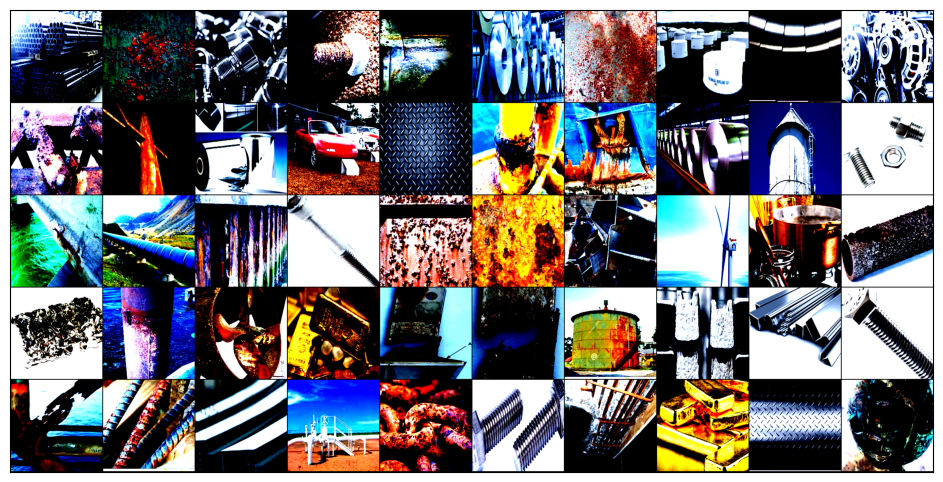

In [10]:
show_batch(train_dl)

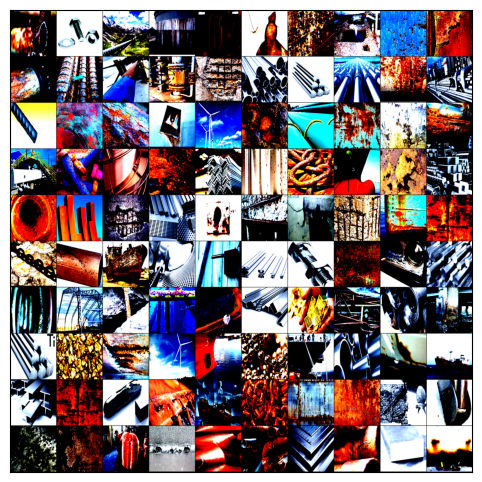

In [11]:
show_batch(test_dl)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
##Model Building

In [14]:
class Corrosion_Detection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # imput : 3 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # output : 32 x 224 x 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 28 x 28

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, xb):
        return self.network(xb)

In [15]:
model = Corrosion_Detection()
model

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = model.to(device)

In [22]:
@torch.no_grad()# The @ does not allow tracking of gradients
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
model = to_device(Corrosion_Detection(), device)

In [24]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [25]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [0], train_loss: 0.6917, val_loss: 0.6707, val_acc: 0.6300
Epoch [1], train_loss: 0.6680, val_loss: 0.6337, val_acc: 0.6300
Epoch [2], train_loss: 0.6362, val_loss: 0.5954, val_acc: 0.6900
Epoch [3], train_loss: 0.6011, val_loss: 0.6056, val_acc: 0.6900
Epoch [4], train_loss: 0.5532, val_loss: 0.5746, val_acc: 0.7100
Epoch [5], train_loss: 0.5181, val_loss: 0.6117, val_acc: 0.6700
Epoch [6], train_loss: 0.4707, val_loss: 0.5935, val_acc: 0.7000
Epoch [7], train_loss: 0.4478, val_loss: 0.6101, val_acc: 0.7000
Epoch [8], train_loss: 0.3947, val_loss: 0.6286, val_acc: 0.7000
Epoch [9], train_loss: 0.3570, val_loss: 0.6541, val_acc: 0.6900


In [26]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of Epochs');

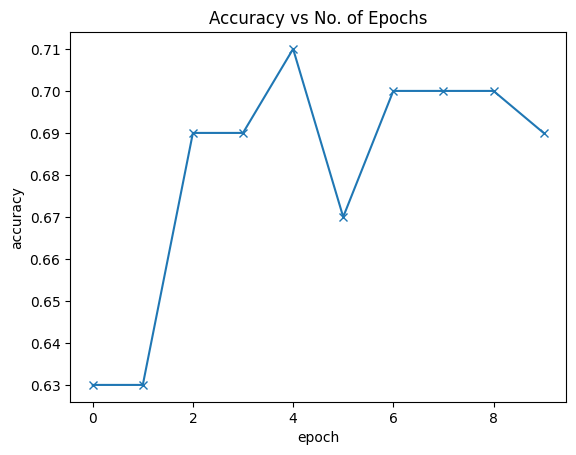

In [27]:
plot_accuracies(history)

In [28]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x.get('val_loss') for x in history]
  plt.plot(val_losses, '-rx')
  plt.plot(train_losses, '-bx')
  plt.xlabel('epoch')
  plt.ylabel(['Validation', 'Training'])
  plt.title('Loss vs NO. of Epochs')

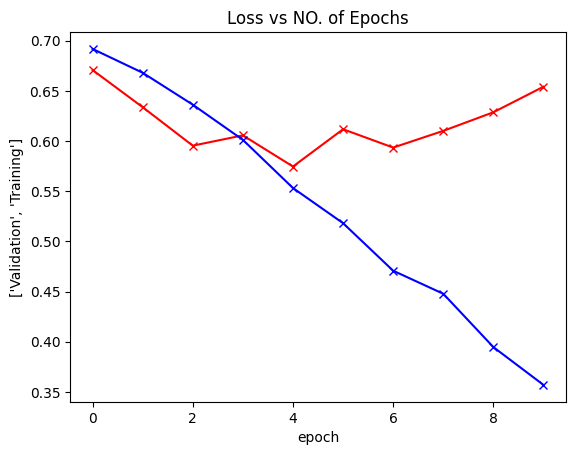

In [29]:
plot_losses(history)

**Model Save and Test**

In [30]:
import torch
import cv2
import torchvision.transforms as transforms

In [31]:
torch.save(model.state_dict(), '/content/drive/My Drive/Corrosion_Detection.pth')

In [32]:
def predict_single(image, model):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    # _, preds = torch.max(yb, dim = 1);
    # print(preds[0].item())
    # print("Prediction: ", prediction[0].item())
    prediction = preds[0]
    a = prediction[0].item()
    b = prediction[1].item()
    print(a, b);
    if a>b :
        print("Corrosion")
    else:
        print("No Corrosion")
    plt.imshow(image.cpu().permute(1, 2, 0))

In [33]:
# path = '/content/drive/MyDrive/Corrosion_Detection.pth'
path = '/content/drive/My Drive/Corrosion_Detection.pth'
model = Corrosion_Detection()
model.load_state_dict(torch.load(path))
model = to_device(model, device)
model.eval()

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

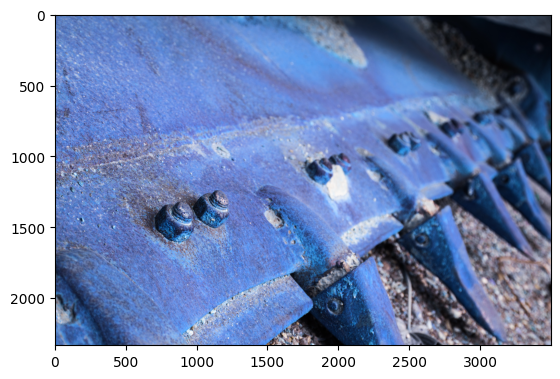

In [36]:

image_path = f"{DATASET_DIR}/corroded/000578.jpg"
image = cv2.imread(image_path)
# print(type(image))
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
og_image = image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])

])

tensor = transform(image)

**Model Prediction**

In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, class_names=None, device="cpu", show=True):
    """
    Predict a single image from file path.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained PyTorch model.
        transform (torchvision.transforms): Transform pipeline for preprocessing.
        class_names (list, optional): List of class names.
        device (str): 'cpu' or 'cuda'.
        show (bool): Whether to display the image with prediction.

    Returns:
        str: Predicted class name.
        float: Confidence score.
    """
    # Load image (PIL preferred for torchvision transforms)
    image = Image.open(image_path).convert("RGB")

    # Apply transforms
    tensor = transform(image).to(device)

    # Add batch dimension
    input_tensor = tensor.unsqueeze(0)

    # Model inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probs, 1)

    # Get class name
    if class_names:
        predicted_class = class_names[predicted_idx.item()]
    else:
        predicted_class = str(predicted_idx.item())

    # Show image with prediction
    if show:
        img = tensor.cpu().permute(1, 2, 0).numpy()
        # Undo ImageNet normalization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = std * img + mean
        img = img.clip(0, 1)

        plt.imshow(img)
        plt.title(f"{os.path.basename(image_path)}\nPredicted: {predicted_class} ({confidence.item():.2f})")
        plt.axis("off")
        plt.show()

    print(f"Image: {image_path} → Predicted: {predicted_class}, Confidence: {confidence.item():.2f}")
    return predicted_class, confidence.item()


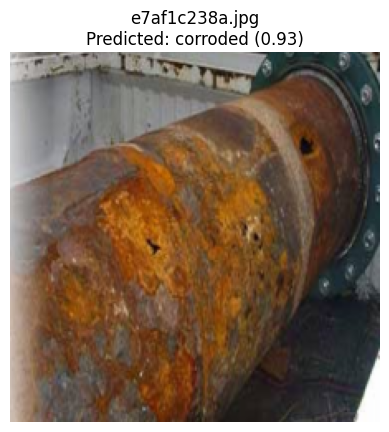

Image: /content/drive/MyDrive/dataset/corroded/e7af1c238a.jpg → Predicted: corroded, Confidence: 0.93


('corroded', 0.9321466088294983)

In [49]:
import os

class_names = ["corroded", "non_corroded"]

predict_image(
    os.path.join(DATASET_DIR, "corroded/e7af1c238a.jpg"),
    model,
    transform,
    class_names=class_names,
    device=device
)